<a href="https://colab.research.google.com/github/rfvassallo/ComputerVisonClasses/blob/master/lesson09-rectified_reconstruction/dense_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

(240, 320)


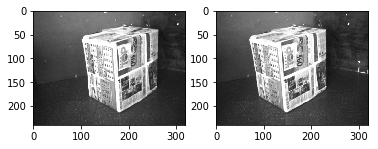

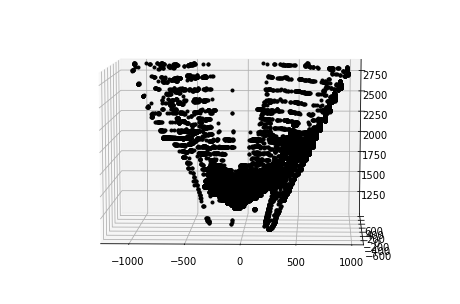

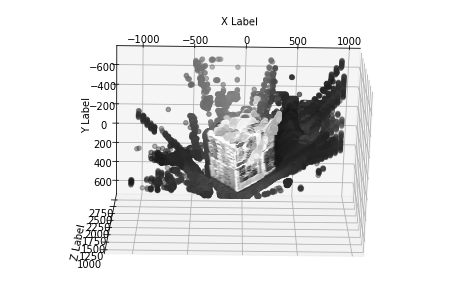

In [3]:
import cv2
import numpy as np
import numpy.matlib 
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys


#########################
def calc_disp (imL,imR,line,focus,baseline):
    # Funcao que busca pixels de imR em imL

    # Tamanho da janela de comparação em torno de cada pixel
    window = 11
    half = np.round((window-1)/2) #Metade da janela


    # Threshold de filtragem do SSD
    th = 0.08


    # Define as profundidades de busca para gerar as coordenadas na linha
    # epipolar
    z_ini = 1000.0
    z_fim = 5000.0

    # Valor máximo de coluna (coordenada x) da imagem
    x_max = imL.shape[1]

    # Valores de coluna que serão percorridos na linha epipolar da imagem
    # direita
    values_xR = np.arange(half,(x_max-half)).astype(float)
    

    # Define coordenadas de inicio e fim para varredura de busca por
    # correspondência na linha epipolar da imagem esquerda
    # ATENÇÃO: o valor de xL_fim é menor que xL_ini
    xL_ini = np.round(float(focus*baseline)/float(z_ini) + values_xR)
    xL_fim = np.round(float(focus*baseline)/float(z_fim) + values_xR)
    

    ###### PAREI AQUI
    # Verificando se ultrapassa os limites permitidos para busca na imagem

    xL_fim[np.where(xL_fim>(x_max-half-1))] = x_max-half-1
    xL_fim[np.where(xL_fim<(half))] = half
    xL_ini[np.where(xL_ini>(x_max-half-1))] = x_max-half-1
    xL_ini[np.where(xL_ini<(half))] = half

    # Guarda a diferença entre as coordenadas x (coluna) inicial e final dos
    # pontos a serem percorridos na linha epipolar da esquerda para serem
    # comparados com cada ponto x (coluna) da linha epipolar da direita
    difer = xL_ini - xL_fim +1
    

    # Inicia vetores com o tamanho da linha da imagem para conter a disparidade, 
    # os pontos da direita, seus matchings na esquerda e valores de SSD

    dim = (imL[line,:]).shape
    xR = np.zeros(dim)
    match_xL = np.zeros(dim)
    im_disp = -np.ones(dim)
    im_ssd = -np.ones(dim)

    # Varrer a linha da imagem direita buscando o matching na esquerda
    # Varre a linha epipolar para cada pixel
    for indR in range(len(values_xR)):
        
        # Recupera o indice da coluna (coordenada x) do pixel da imagem da
        # direita que será comparado com os pixels da imagem esquerda
        x = values_xR[indR]
        
        # Separa a janela de pixels em torno do pixel

        winR = imR[int(line-half):int(line+half+1),int(x-half):int(x+half+1)].astype(float)
        

        # Inicializa vetor para guardar valores de SSD calculados dentro do 
        # próximo "for"

        ssd = np.zeros((1,int(difer[indR])))
        # Varrer a linha epipolar da imagem esquerda comparando cada janela em
        # torno dos pixels da esquerda com a janela do pixel da imagem direita
        # para encontrar a correspondência   
        # Vocês podem trocar as variáveis se quiserem
        
        

        for indL in range(int(difer[indR])):   
            
            # Calcula o indice da coluna do pixel na imagem esquerda a ser comparado
            xL = xL_ini[indR]-indL#+1
            # Construir a janela em torno do pixel da esquerda centrado em
            # no indice calculado
            
            winL = imL[int(line-half):int(line+half+1),int(xL-half):int(xL+half+1)].astype(float)
           
            # Compara janela em torno do ponto para buscar o correspondente
            # Calcular o SSD entre a janela da esquerda e a da direita, e
            # armazenar em um vetor
            # SSD - Soma do quadrado das diferenças
            #ssd(indL) = sum(sum(sum((winR-winL).^2)))/(window*window*size(imR,3));       % Para o caso de imagens coloridas 
            #print(winR,winL)
            ssd[0,indL] = np.sum(np.square((winR-winL)/255))/float(window*window)            

        
        # Encontrrar o menor SSD entre os valores calculados para 
        # selecionar o pixel (coordenada x) sobre a linha epipolar da imagem
        # esquerda que corresponda a ele
        # Esse pixel deve representar o correspondente ao pixel na linha 
        # epipolar da imagem direita selecionado pelo indR
        
        
        ssdmin=np.amin(ssd)
        ind = np.argmin(ssd)

       
        
        
        # Se o valor do menor SSD encontrado for menor ou igual ao threshold 
        # definido inicialmente (representando um bom matching),
        # guardar nos vetores de saída:     
        # o valor de x (coluna) na imagem direita em xR(x)
        # o valor de x (coluna) do correspondente na imagem esquerda em match_L(x) 
        # o valor da disparidade em im_disp 
        # o valor do SSD em im_ssd
        #    
        # Se o valor do menor SSD não atender à condição, considera-se que não
        # há correspondência entre o pixel da imagem direita com nenhum pixel
        # da imagem esquerda
        
        if (ssdmin <= th):
            pos = int(x)
            xR[pos] = x
            match_xL[pos] = xL_ini[indR]-ind
            # if line == 97 and indR == 173:
            #     print(ind)
            #     print(match_xL[pos])
            #     exit()
            if (xL_ini[indR]-ind-x == 0):
                im_disp[pos] = 0.00001
            else:
                im_disp[pos] = xL_ini[indR]-ind-x
            im_ssd[pos] = ssdmin
        
        
        
    return xR, match_xL, im_disp, im_ssd

###################################




# Read images
IR = cv2.imread('direita.ppm',0)  # right image
IL = cv2.imread('esquerda.ppm',0) # left image

print(IR.shape)
# Show images and matchings

fig, ax = plt.subplots(nrows=1, ncols=2)
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(IL,cv2.COLOR_GRAY2BGR))
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(IR,cv2.COLOR_GRAY2BGR))
plt.show(block=False)

img_size = IL.shape

# intrinsic parameter matrix
fm = 403.657593 # Fical distantce in pixels
cx = 161.644318 # Principal point - x-coordinate (pixels) 
cy = 124.202080 # Principal point - y-coordinate (pixels) 
bl = 119.929 # baseline (mm)
# for the right camera    
K_right = np.array([[ fm, 0, cx],[0, fm, cy],[0, 0, 1.0000]])

# for the left camera
K_left = np.array([[fm, 0, cx],[0, fm, cy],[0, 0, 1.0000]])

# Extrinsec parameters
# Translation between cameras
T = np.array([-bl, 0, 0]) 
T = T/np.linalg.norm(T)
# Rotation
R = np.array([[ 1,0,0],[ 0,1,0],[0,0,1]])


# Define a linha inicial e final para a reconstrução densa

l_ini = 26
l_fim = 217



# Inicializa matrizes do tamanho da imagem para armazenar as
# correspondências entre pontos da imagem direita (pts_R) e da imagem
# esquerda (pts_L), a disparidade (xL - xR) de cada par correspondente, e o
# valor da comparação por SSD (soma do quadrado das diferenças)
pts_R = np.zeros(img_size)
pts_L = np.zeros(img_size)
disp = -np.ones(img_size)
im_ssd = -np.ones(img_size)



# Encontra a correspondência entre os pixels. Em pts_R e pts_L serão
# gravados esses pixels, e em disp a diferença entre as coordenadas x dos
# pontos

# Varredura de cada linha:
for l in range (l_ini,l_fim):
    pts_R[l,:],pts_L[l,:],disp[l,:],im_ssd[l,:] = calc_disp(IL,IR,l,fm,bl)
    


# Calcula a profundidade
z = np.ones(disp.shape).astype(float)*fm*bl

z = np.divide(z,disp)


# Elimina as profundidades errôneas
good = np.where((z>0.0) & (z<3000.0))

#print(good)

# Calcula os pontos tridimensionais
uR = pts_R
vR = np.matlib.repmat(np.arange(img_size[0]).reshape(-1, 1),1,img_size[1])
up1 = uR[good]
vp1 = vR[good]
zp1 = z[good]
xp1 = np.multiply(zp1,((up1-cx)/fm))
yp1 = np.multiply(zp1, ((vp1-cy)/fm))







# Plota os pontos reconstruídos
fig = plt.figure(figsize=(8,15))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xp1, yp1, zp1, '.k')
ax.set_aspect('equal')
ax.view_init(elev=8,azim=-88)
plt.show(block=False)


# Plota pontos com a cor dos pixels da imagem
#step = 10
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(xp1[0:step:len(xp1)],yp1[0:step:len(yp1)],zp1[0:step:len(zp1)], 20, IR[up1[0:step:len(up1)],vp1[0:step:len(vp1)]])
#ax.set_aspect('equal')
#plt.show()


pixel_color=[]



for i in range(xp1.shape[0]):
    pixel_color.append ([IR[int(vp1[i]),int(up1[i])],IR[int(vp1[i]),int(up1[i])],IR[int(vp1[i]),int(up1[i])]])

pixel_color = np.asarray(pixel_color)



# Plota pontos com a cor dos pixels da imagem
fig = plt.figure(figsize=(8,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xp1, yp1, zp1, c=pixel_color/255.0)
ax.set_aspect('equal')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.view_init(elev=-71,azim=-91)

plt.show()

